# Target Scan to identify good spots

random positions on the target

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from scipy.stats import binned_statistic_2d
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [8]:
fname = "2020_10_30.hdf"
dset_name = "1604095725 scan target R0 F2 with RC P2 F1"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [9]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [11]:
idx_pairs = {idx_pxie: find_nearest_idx(data_devices['ZaberTMM']['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()

In [231]:
pxie_indices = np.array(list(idx_pairs.keys()))
zaber_indices = np.array(list(idx_pairs.values()))


indices_sort = np.argsort(pxie_indices)
pxie_indices = pxie_indices[indices_sort]
zaber_indices = zaber_indices[indices_sort]

# axes are flipped, e.g. axis 1 is y on the mirror mount and axis 2 is x
y_mirror = data_devices['ZaberTMM']['x'][zaber_indices]
x_mirror = data_devices['ZaberTMM']['y'][zaber_indices]
data = np.array([pxie[idx][:,pmt_channel] for idx in pxie_indices])

data = -np.array([d - np.mean(d[:250]) for d in data])
integral = np.trapz(data, axis = 1)

stat, x_edge, y_edge, _ = binned_statistic_2d(x_mirror, y_mirror, integral, lambda x: np.nanmean(x), bins = 15, 
                                              expand_binnumbers = True)

In [244]:
counter = np.zeros([15,15])
traces_binned = np.zeros([15,15,2000])
for (idx, idy), trace in zip(_.T, data):
    traces_binned[idx-1,idy-1] += trace
    counter[idx-1,idy-1] += 1
traces_binned /= counter[:,:,np.newaxis]
    
traces_binned -= np.mean(traces_binned[:,:,:250], axis = 2)[:,:,np.newaxis]
integrals_binned = np.trapz(traces_binned, axis = 2)
integrals_binned[integrals_binned == 0] = np.nan

<ipython-input-244-d25d5b4bb490>:6: RuntimeWarning: invalid value encountered in true_divide
  traces_binned /= counter[:,:,np.newaxis]


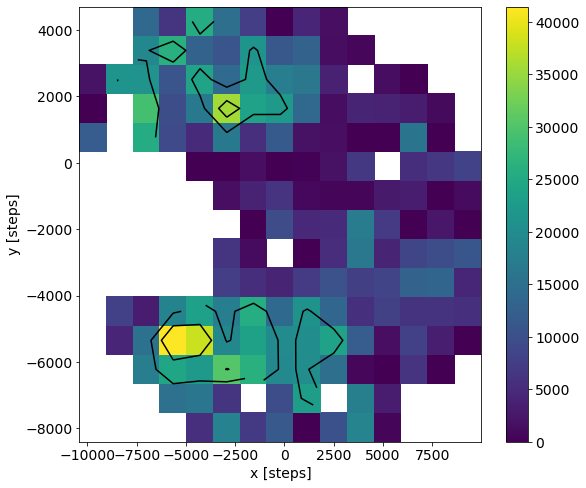

In [245]:
x_bin_width = np.diff(x_edge)[0]
y_bin_width = np.diff(y_edge)[0]
X, Y = np.meshgrid(x_edge,y_edge)

fig, ax = plt.subplots(figsize = (9,8))
cs = ax.pcolormesh(X,Y,integrals_binned, vmin = 0)
ax.contour(X[:-1,:-1]+x_bin_width/2,Y[:-1,:-1]+y_bin_width/2,stat, levels = [2e4,3e4], colors = 'k')

cbar = fig.colorbar(cs)

ax.set_xlabel('x [steps]')
ax.set_ylabel('y [steps]')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

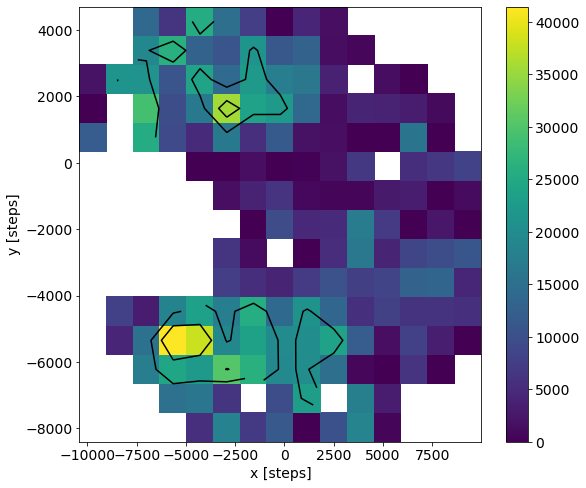

In [246]:
X, Y = np.meshgrid(x_edge,y_edge)

fig, ax = plt.subplots(figsize = (9,8))
cs = ax.pcolormesh(X,Y,stat, vmin = 0)
ax.contour(X[:-1,:-1]+x_bin_width/2,Y[:-1,:-1]+y_bin_width/2,stat, levels = [2e4,3e4], colors = 'k')

cbar = fig.colorbar(cs)

ax.set_xlabel('x [steps]')
ax.set_ylabel('y [steps]')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)